# Generating Samples to Question Trained Models

Find the paper here: https://arxiv.org/pdf/2502.06658 

And the Github repo here: https://github.com/sibirbil/EvD

```
cd <path-to-week-4>

git clone https://github.com/sibirbil/EvD.git

python3.11 -m venv evd_venv
source evd_venv/bin/activate

pip install ipykernel

python -m ipykernel install --user --name=evd_venv

pip install jax pandas scikit-learn flax datasets seaborn
```

In [ ]:
import sys
import os
sys.path.insert(1, os.path.dirname(os.getcwd())+'/04_otherXAI/EvD')

import langevin
import pandas as pd
import flax.linen as nn
import numpy

import jax
import jax.random as random
import jax.numpy as jnp
import datasets
import model_contrast_functions

import create_datasets
from functools import partial
import nets, train, optax, utils
import matplotlib.pyplot as plt
import model_contrast_functions

## Generating prediction-risky samples

### Load FICO dataset

In [ ]:
# load the data
df, X, y, scaler = create_datasets.get_fico()

N = X.shape[0]
key = random.key(24)
init_key, train_key, mala_key, noise_key, x0_key = random.split(key, 5)

## Get the data in JAX format

train_idx = random.choice(key, jnp.arange(N), shape = (int(0.9*N),),  replace=False)
test_idx = jnp.delete(jnp.arange(N), train_idx)
X_train = jnp.array(X)[train_idx]
y_train = jnp.array(y)[train_idx]
X_test = jnp.array(X)[test_idx]
y_test = jnp.array(y)[test_idx]

ds_train = datasets.Dataset.from_dict({'x':X_train, 'y':y_train})
ds_test = datasets.Dataset.from_dict({'x':X_test, 'y':y_test})
ds_train = ds_train.with_format('jax')
ds_test = ds_test.with_format('jax')



### Train MLP network

In [3]:
## Define the MLP network with dropout and train it.

mlp = nets.MLP_with_dropout(features = [128,32,8,2], dropout_rate=0.2)
exp_decay_schedule = optax.schedules.exponential_decay(0.01,100, 0.9,500, True, end_value = 1e-5)
adam = optax.adam(learning_rate = exp_decay_schedule)
ts = train.create_train_state(init_key, mlp, X_train[0].shape, adam)
ts = train.train(train_key,ts, ds_train, 128, 10000)
test_acc, test_loss = train.eval_step(ts, ds_test[:])

print(f"The accuracy on the test set {test_acc} with loss {test_loss}")

Batches: 0,	Train Acc: 53.00%,	loss: 0.6830
Batches: 100,	Train Acc: 71.40%,	loss: 0.5715
Batches: 200,	Train Acc: 72.00%,	loss: 0.5584
Batches: 300,	Train Acc: 72.10%,	loss: 0.5525
Batches: 400,	Train Acc: 73.60%,	loss: 0.5473
Batches: 500,	Train Acc: 70.90%,	loss: 0.5636
Batches: 600,	Train Acc: 73.00%,	loss: 0.5477
Batches: 700,	Train Acc: 71.70%,	loss: 0.5506
Batches: 800,	Train Acc: 71.70%,	loss: 0.5638
Batches: 900,	Train Acc: 73.80%,	loss: 0.5282
Batches: 1000,	Train Acc: 76.00%,	loss: 0.5253
Batches: 1100,	Train Acc: 72.30%,	loss: 0.5484
Batches: 1200,	Train Acc: 71.30%,	loss: 0.5509
Batches: 1300,	Train Acc: 73.10%,	loss: 0.5333
Batches: 1400,	Train Acc: 74.50%,	loss: 0.5166
Batches: 1500,	Train Acc: 73.70%,	loss: 0.5406
Batches: 1600,	Train Acc: 72.20%,	loss: 0.5480
Batches: 1700,	Train Acc: 71.90%,	loss: 0.5406
Batches: 1800,	Train Acc: 74.00%,	loss: 0.5362
Batches: 1900,	Train Acc: 72.90%,	loss: 0.5493
Batches: 2000,	Train Acc: 74.80%,	loss: 0.5228
Batches: 2100,	Train Acc:

### Generate prediction-risky samples

In [4]:
## This defines the loss function on the parameters for using MALA.

def F_function(
    X       : jax.Array,
    y       : jax.Array,  #integer labels
    model   : nn.Module,
    beta    : jnp.float_
    ):
    def F(params):
        logits = model.apply(params, X, is_training= False)
        losses = optax.softmax_cross_entropy_with_integer_labels(logits, y)
        return beta*jnp.mean(losses)
    return jax.jit(F)


betaF = 1000.
etaF = 0.1/betaF
N_params = 10000
params_state = mala_key, ts.params
F = F_function(ds_train['x'], ds_train['y'], mlp, betaF)
hypsF = F, jax.grad(F), etaF
_, traj_params = langevin.MALA_chain(params_state, hypsF, N_params)


def G_function_risky(
    traj_params,    # a single PyTree
    target          : jax.Array,    # target softmax values of shape (k,)
    model           : nn.Module,
    beta            : jnp.float_    # inverse temperature
):
    model_fn = partial(model.apply, is_training =False)
    def G(x):
        logits = jax.vmap(model_fn, in_axes = (0, None))(traj_params, x)
        losses = -jax.nn.log_softmax(logits) @ target
        return beta*jnp.mean(losses)
    
    return jax.jit(G)


betaG= 1000.
etaG = 0.01/betaG
etaG = utils.sqrt_decay(etaG)
N_data = 20000

#x0 = jax.random.uniform(x0_key, shape = X_train[0].shape)
x0 = X_train[0]
x_state = x0_key, x0

G_risky = G_function_risky(traj_params, jnp.array([1.0, 1.0]), mlp, betaG)
hypsG_risky = G_risky, jax.grad(G_risky), etaG, 0., 1.
_, risky_traj_x = langevin.MALA_chain(x_state, hypsG_risky, N_data)

risky_traj_logits = mlp.apply(ts.params, risky_traj_x, is_training = False)
risky_traj_probs = jax.nn.softmax(risky_traj_logits)
risky_traj_preds = jnp.argmax(risky_traj_probs, axis = -1)

generated_sample = risky_traj_x[-500:,]
inverted = scaler.inverse_transform(generated_sample)

original_data = df.drop(df.columns[0], axis=1)

data_path = jnp.column_stack([risky_traj_probs[:, 1] , risky_traj_x])
data_path_df = pd.DataFrame(data_path, columns = df.columns)

# Adjust columns for the inverted dataset
inverted_df = pd.DataFrame(inverted, columns=original_data.columns)
y_prob = risky_traj_probs[-500:, 1] 

mean_y_prob = numpy.mean(y_prob)       
std_y_prob = numpy.std(y_prob)  

print(f"Mean: {mean_y_prob}")
print(f"Standard Deviation: {std_y_prob}")

Mean: 0.5431200861930847
Standard Deviation: 0.01281467080116272


### Visualize results

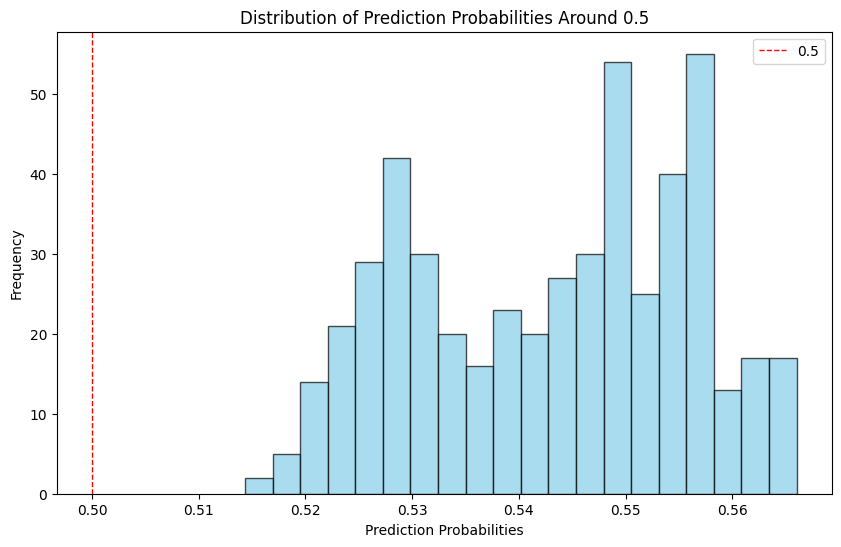

In [5]:
# Plot distribution
plt.figure(figsize=(10, 6))
plt.hist(y_prob , bins=20, edgecolor='black', color='skyblue', alpha=0.7)
plt.axvline(0.5, color='red', linestyle='dashed', linewidth=1, label='0.5')

plt.xlabel('Prediction Probabilities')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Probabilities Around 0.5')
plt.legend()
plt.show()

### Compare datasets

In [9]:
## Check the maximum and minimum values in the synthetic data and compare it with the original data
model_contrast_functions.print_max_min_values(inverted, original_data.columns, "Synthetic Data")
model_contrast_functions.print_max_min_values(numpy.array(original_data), original_data.columns, "Original Data")


Max and Min values for Synthetic Data:
Feature 'ExternalRiskEstimate': Max = 78.0, Min = 74.9
Feature 'MSinceOldestTradeOpen': Max = 165.2, Min = 127.8
Feature 'MSinceMostRecentTradeOpen': Max = 11.4, Min = 1.8
Feature 'AverageMInFile': Max = 73.0, Min = 63.7
Feature 'NumSatisfactoryTrades': Max = 28.0, Min = 25.5
Feature 'NumTrades60Ever2DerogPubRec': Max = 1.8, Min = 1.2
Feature 'NumTrades90Ever2DerogPubRec': Max = 0.4, Min = 0.0
Feature 'PercentTradesNeverDelq': Max = 89.2, Min = 86.9
Feature 'MaxDelq2PublicRecLast12M': Max = 5.1, Min = 4.8
Feature 'MaxDelqEver': Max = 7.3, Min = 7.1
Feature 'NumTotalTrades': Max = 30.1, Min = 26.0
Feature 'NumTradesOpeninLast12M': Max = 2.5, Min = 2.1
Feature 'PercentInstallTrades': Max = 37.5, Min = 33.4
Feature 'NumInqLast6M': Max = 4.1, Min = 1.4
Feature 'NumInqLast6Mexcl7days': Max = 3.5, Min = 1.4
Feature 'NetFractionRevolvingBurden': Max = 27.4, Min = 19.8
Feature 'NumRevolvingTradesWBalance': Max = 3.1, Min = 2.0
Feature 'NumInstallTradesWB

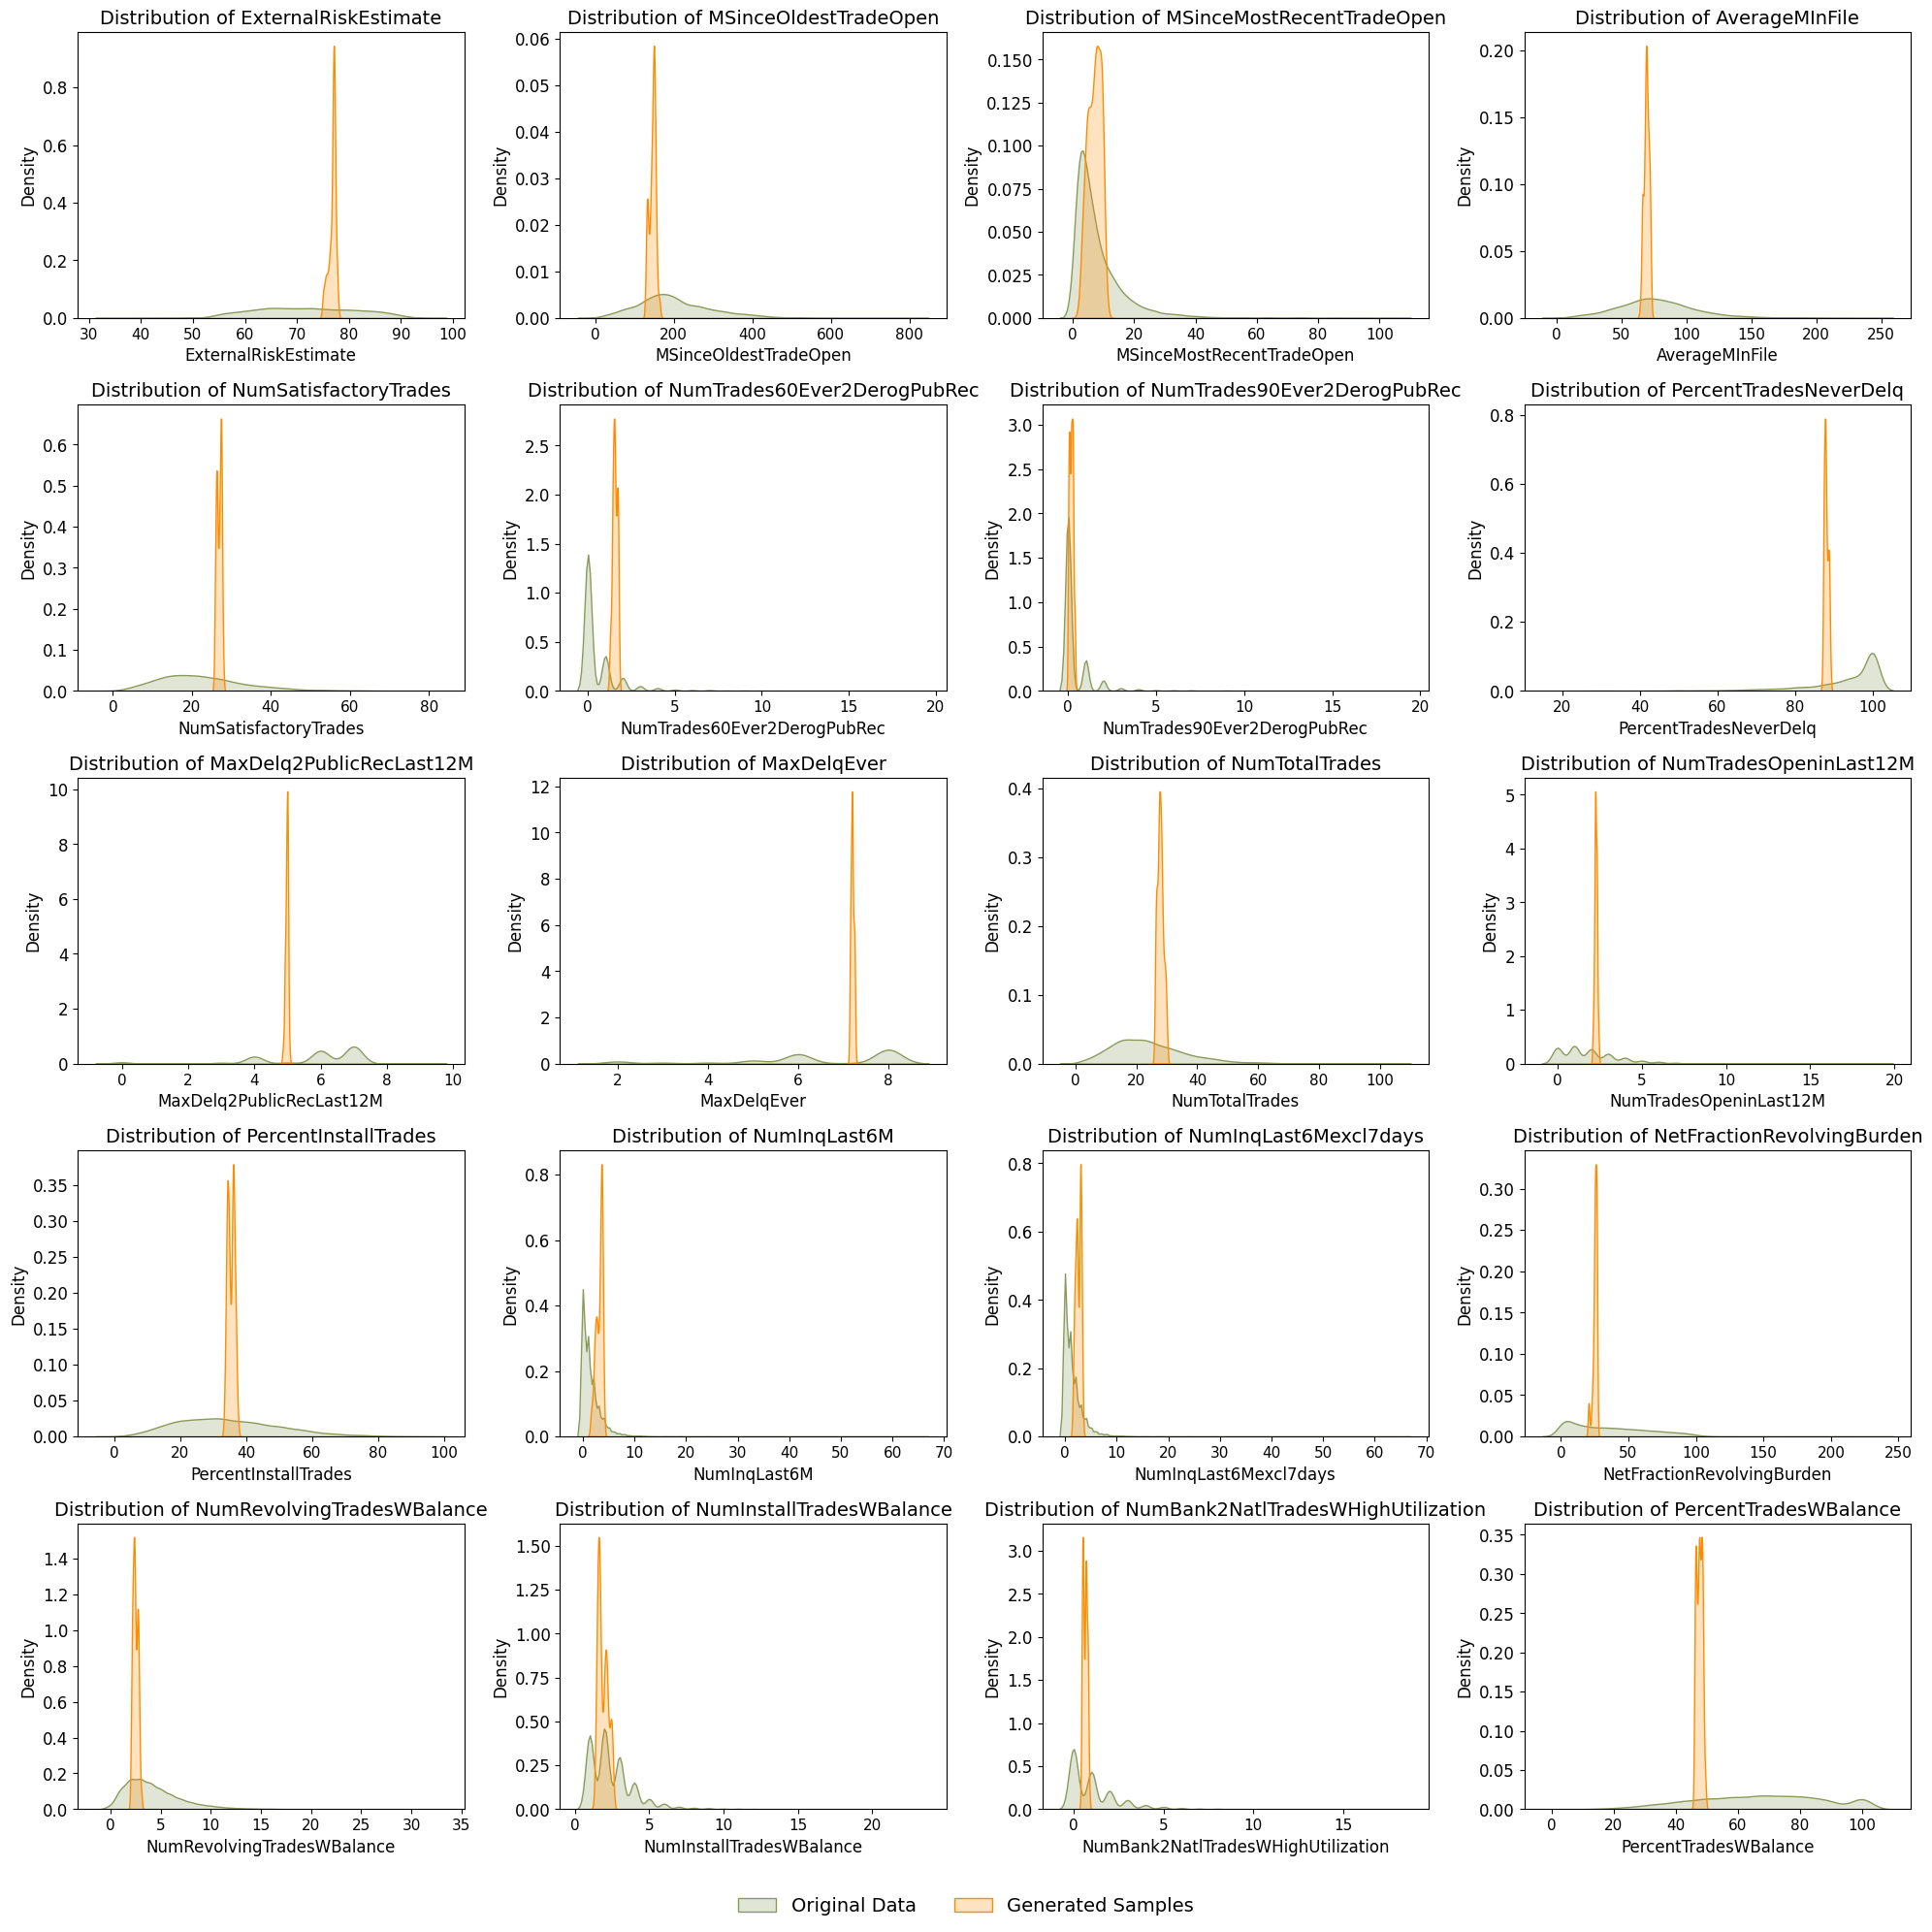

In [10]:
# visualize
model_contrast_functions.compare_datasets_gridAll(data1=original_data, data2=pd.DataFrame(inverted, columns=original_data.columns))